### Test - Synthetic Diagnostic + Interferometry

</b> Author:   </b>  Louis Evans     </br>
</b> Reviewer: </b>  Stefano Merlini

### Import relevant files:

In [18]:
#%matplotlib widget
import numpy as np
import vtk
from vtk.util import numpy_support as vtk_np
import matplotlib.pyplot as plt
import gc

import sys

#add path
sys.path.insert(0, '../../synthPy_restructured')     # import path/to/synthpy

import beam as beam_initialiser
import diagnostics as diag
import domain as d
import propagator as p
import utils
import x_ray_diffraction as xray

import importlib
importlib.reload(beam_initialiser)
importlib.reload(diag)
importlib.reload(d)
importlib.reload(p)
importlib.reload(utils)

<module 'utils' from 'c:\\Users\\qinal\\OneDrive - Imperial College London\\UROP\\synthPy\\examples\\notebooks\\../../synthPy_restructured\\utils.py'>

To use the ray tracer, first create a 'domain', load the domain with an electron distribution, calculate electron gradients, initialise a beam, and solve!
\
\
The output can either be plotted, or passed further through ray optics for synthetic diagnostics

In [19]:
# define some extent, the domain should be distributed as +extent to -extent, does not need to be cubic
extent_x = 5e-3
extent_y = 5e-3
extent_z = 10e-3

n_cells = 100

#x = np.linspace(-extent_x, extent_x, n_cells)
#y = np.linspace(-extent_y, extent_y, n_cells)
#z = np.linspace(-extent_z, extent_z, n_cells)

probing_extent = extent_z
probing_direction = 'z'

lengths = 2 * np.array([extent_x, extent_y, extent_z])

print("Garbage collection count:", gc.collect())

#domain = d.ScalarDomain(x = x, y = y, z = z, extent= probing_extent, probing_direction = probing_direction)     # create domain
# Much simpler domain function, no longer needlessly takes in beam values, they are fully seperated
domain = d.ScalarDomain(lengths, n_cells) # B_on = False by default

# clear we should do manual garbage collection of some variety in d.ScalarDomain function
print("Garbage collection count:", gc.collect())

Garbage collection count: 3053
Garbage collection count: 0


Load some domain distribution

In [20]:
# load some external pvti
# import utils.handle_filetypes as load
# ne, dim, spacing = load.pvti_readin(filename)
# or load a test distribution

#domain.ne = np.full((100, 100, 100), 1e24)
domain.ne = None
domain.refrac_field = None
#domain.test_exponential_cos(Ly = domain.y_length * 0.5)
#domain.josie_test(radius = 2e-3, position = (0,0), n1 = 1, n2 = 1.5)
#domain.test_linear_cos(s2 = 0.9, Ly=domain.y_length *0.25)
#domain.test_slab(s = 2)
#domain.test_onaxis_sin(A = 0.5)
domain.double_gaussian(d = 0.5e-3)
#domain.gaussian()
domain.external_Te(np.full((n_cells, n_cells, n_cells), 2e5))
domain.external_mass_density(np.full((n_cells, n_cells, n_cells), 2e3))

Solve gradients, initialise beam, and solve

In [21]:
wl = 10e-9 #define laser wavelength

# initialise beam
Np = 100000  # number of photons
divergence = 5e-5   # realistic divergence value
beam_size = extent_x    # beam radius
ne_extent = probing_extent  # so the beam knows where to initialise initial positions
beam_type = 'circular'

initial_rays = beam_initialiser.Beam(Np, beam_size, divergence, ne_extent, probing_direction, wl, beam_type)
tracer = p.Propagator(domain, initial_rays, inv_brems = False, x_ray = False, phaseshift = True, refrac_field = False, elec_density = True)
# solve ray trace
tracer.calc_dndr()
tracer.set_up_interps()

final_rays = tracer.solve(parallelise = False, jitted = True, Nt = 2)
times = tracer.t
positions = tracer.Beam.positions
jones_vector = tracer.Beam.rf
amplitudes = tracer.Beam.amplitudes
phases = tracer.phase_integral
#print("phase shift from derivative:", tracer.Beam.phases[:, -1])



#final_rays, final_rays_to_Jonesvector = tracer.Beam.rf, tracer.Beam.Jf
print("\nCompleted ray trace in", np.round(tracer.duration, 3), "seconds.")



  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  9.435e-11]
        y: [[ 2.279e-03  2.279e-03]
            [-2.183e-03 -2.182e-03]
            ...
            [ 0.000e+00  0.000e+00]
            [ 0.000e+00  0.000e+00]]
      sol: None
 t_events: None
 y_events: None
     nfev: 14
     njev: 0
      nlu: 0
phase shift from line integral: [-6.76420657e-14 -3.10093455e-04 -4.15903492e-11 ... -6.56493902e-13
 -1.07224354e-04 -2.69545931e-12]

Completed ray trace in 4.437 seconds.


In [22]:
#axes1 = plt.axes(projection = "3d")
#print(domain.refrac_field)
#plt.plot(domain.ZZ[:,0,:], domain.XX[:,0,:], domain.refrac_field[:,0,:], ".")
#axes1.plot(domain.ZZ[:,0,:], domain.XX[:,0,:], tracer.dndz_interp(()), ".")

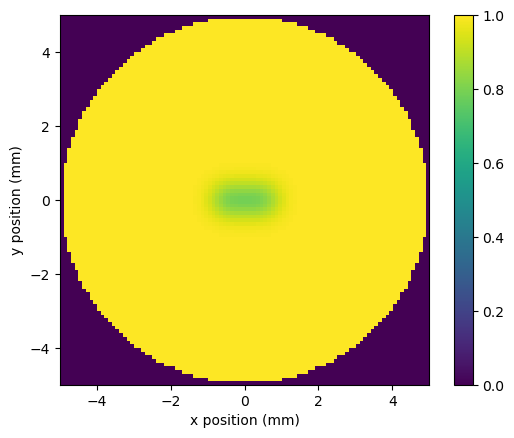

In [23]:
from scipy.interpolate import CloughTocher2DInterpolator as CT2D
from scipy.interpolate import LinearNDInterpolator as LNDI
#phases_interp = CT2D((tracer.Beam.rf[0], tracer.Beam.rf[2]), phases[:,-1], fill_value = 0.0)
phases_interp = CT2D((tracer.Beam.rf[0], tracer.Beam.rf[2]), phases, fill_value = 0.0)
amplitudes_interp = CT2D((tracer.Beam.rf[0], tracer.Beam.rf[2]), amplitudes[:, -1], fill_value = 0.0)

XX, YY = np.meshgrid(tracer.ScalarDomain.x, tracer.ScalarDomain.y)
phase_grid = phases_interp((XX, YY))
amplitude_grid = amplitudes_interp((XX, YY))
k = 2 * np.pi / wl
initial_field = amplitude_grid * np.exp(-1j * phase_grid)

fig0, axs0 = plt.subplots()
im = axs0.imshow(np.real(initial_field)**2, extent = (-5, 5, -5, 5))
axs0.set_xlabel("x position (mm)")
axs0.set_ylabel("y position (mm)")
fig0.colorbar(im, ax = axs0, orientation='vertical', fraction = .1)

Fresnel Number: 200000.0000
Fresnel Number: 18181.8182
Fresnel Number: 9523.8095
Fresnel Number: 6451.6129
Fresnel Number: 4878.0488
Fresnel Number: 3921.5686


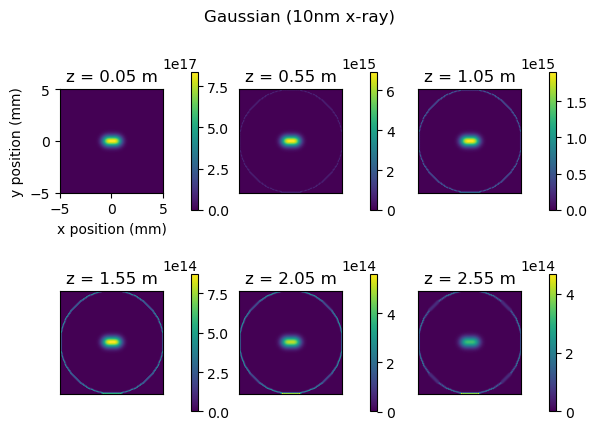

In [24]:
a = 2
b = 3
fig, axs = plt.subplots(a,b)
fig.suptitle("Gaussian (10nm x-ray)")
fig.subplots_adjust(wspace = 0.3)
axes = axs.flatten()
final_fields = []

for i in range (0,a*b):
    final_field = xray.propagate(Propagator = tracer, jones_vector = jones_vector, amplitudes = amplitudes, phases = phases,  z = 0.05 + 0.5*i)
    final_fields.append(np.real(final_field)**2)

# fig1, ax1 = plt.subplots()
# fig1.suptitle("Phase at Exit of Plasma (linear electron density)")
# im = ax1.imshow(phase_grid, extent = (-5, 5, -5, 5))
# ax1.set_xlabel("x position (mm)")
# ax1.set_ylabel("y position (mm)")
# fig1.colorbar(im, ax = ax1, orientation='vertical', fraction = .1)

images = []
counter = 0

for ax, data in zip(axs.flatten(), final_fields):
    im = ax.imshow(data, extent = (-5, 5, -5, 5))
    images.append(im)
    if counter == 0:
        ax.set_xlabel("x position (mm)")
        ax.set_ylabel("y position (mm)")
    else:
        ax.set_xticks([])  # Remove x-axis ticks
        ax.set_yticks([])  # Remove y-axis ticks
    ax.set_title(f"z = {0.05 + 0.5*counter} m")
    fig.colorbar(im, ax = ax, fraction = .05, pad = 0.2)
    counter += 1
#plt.savefig("../../../xray_diffraction_gaussian_100_10nm.png",dpi=500, bbox_inches='tight', pad_inches=0.1)

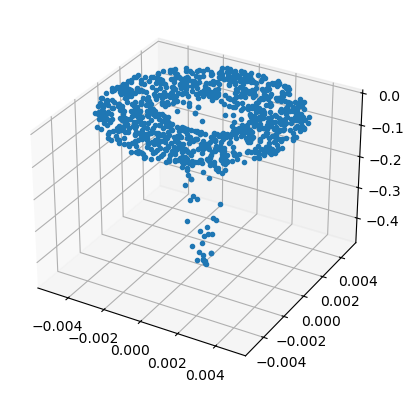

In [25]:
axes = plt.axes(projection = "3d")
num_rays = 1000
indexs = np.random.randint(low = Np, size = num_rays)
plt.plot(jones_vector[0, indexs], jones_vector[2, indexs], phases[indexs], ".")

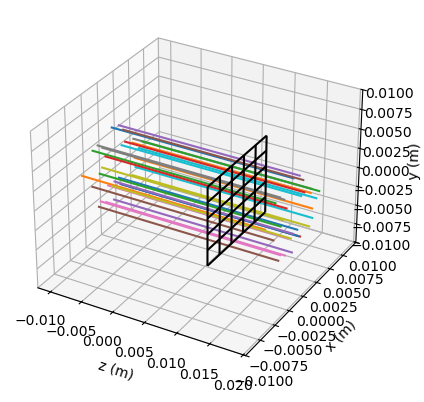

In [26]:
axes = plt.axes(projection = "3d")
num_rays = 30
subset_rays = positions[np.random.randint(low = Np, size = num_rays)]
for i in subset_rays:
   
    x, y, z = zip(*i)
    plt.plot(z, x, y)
    
x_plane = np.linspace(-0.005, 0.005, 100)
y_plane = np.linspace(-0.005, 0.005, 100)
xx, yy =np.meshgrid(x_plane, y_plane)
z_plane = np.full(100, 0.01)
axes.plot_wireframe(z_plane, xx, yy, rcount = 5, ccount = 5, color="k")
axes.set_ylim(-10e-3, 10e-3)
axes.set_zlim(-10e-3, 10e-3)
axes.set_xlabel('z (m)')
axes.set_ylabel('x (m)')
axes.set_zlabel('y (m)')
plt.show()

In [27]:

# fig, ax = plt.subplots()
# tracer.Beam.rf = tracer.Beam.rf*1e3
# refractometer = diag.Refractometry(tracer.Beam)
# refractometer.

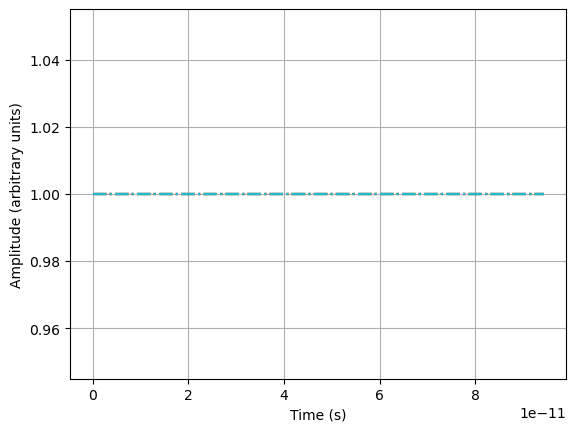

In [28]:
num_rays = 10
subset_rays = amplitudes[np.random.randint(low = Np, size=num_rays)]
for i in subset_rays:
    plt.plot(times, i, "-.")
plt.grid()
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (arbitrary units)")
plt.yscale("linear")
plt.show()


r0 after clearing nan's: (100000, 100000)


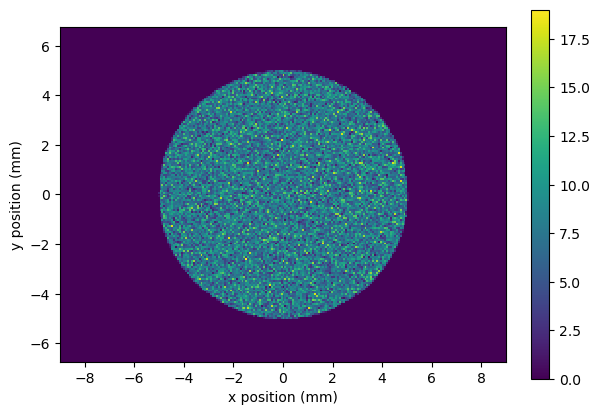

In [29]:
fig, ax = plt.subplots()
tracer.Beam.rf = tracer.Beam.rf*1e3
diagnostic=diag.Diagnostic(tracer.Beam)
diagnostic.histogram(bin_scale=15, clear_mem=True)
diagnostic.plot(ax)
tracer.Beam.rf = tracer.Beam.rf*1e-3

Pass through ray optics: For Shadowgaphy, Schlieren, or Refractometry:


r0 after clearing nan's: (100000, 100000)
Garbage collection count: 34464


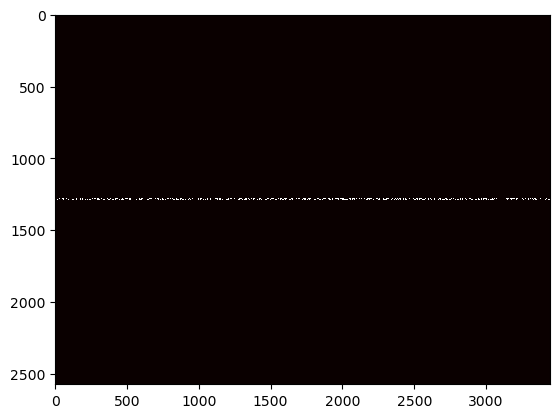

In [30]:
#in the diagnostic initialisation, details on the lens configurations, and detector dimensions can be specified
refractometer = diag.Refractometry(tracer.Beam)
refractometer.incoherent_solve()
# cam't clear_mem if you want to generate other graphs afterwards
refractometer.histogram(bin_scale = 1, clear_mem = False)

#information accessed by .H(istogram) , e.g plt.imshow(refractometer.H)

#plt.imshow(refractometer.H, cmap='hot', interpolation='nearest', clim = (0, 2))
plt.imshow(refractometer.H, cmap = 'hot', interpolation = 'nearest', clim = (0.5, 1))

print("Garbage collection count:", gc.collect())


r0 after clearing nan's: (100000, 100000)
Garbage collection count: 3053


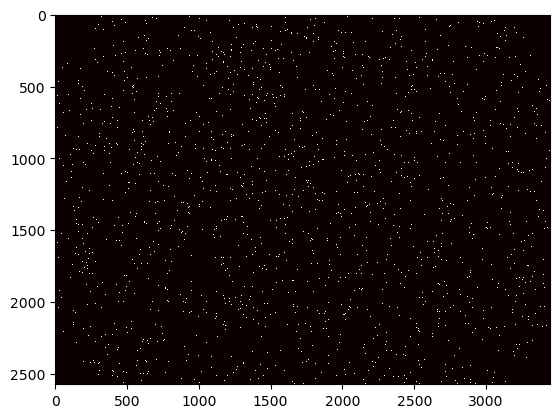

In [31]:
shadowgrapher = diag.Shadowgraphy(tracer.Beam)
shadowgrapher.single_lens_solve()
shadowgrapher.histogram(bin_scale = 1, clear_mem = False)

plt.imshow(shadowgrapher.H, cmap = 'hot', interpolation = 'nearest', clim = (0.5, 1))

print("Garbage collection count:", gc.collect())

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]

r0 after clearing nan's: (0, 0)
Garbage collection count: 3050


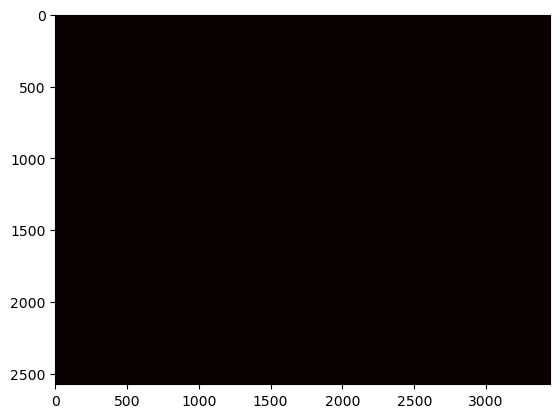

In [32]:
schlierener = diag.Schlieren(tracer.Beam)
schlierener.DF_solve()
schlierener.histogram(bin_scale = 1, clear_mem = True)

plt.imshow(schlierener.H, cmap = 'hot', interpolation = 'nearest', clim = (0.5, 1))

print("Garbage collection count:", gc.collect())

Synthetic Interferometry - This requires some extra steps in the ray tracing to include information on the phase and electric field values

In [33]:
# No need to change the domain (now that code has been seperated out in restructure)



# load some external pvti

# import utils.handle_filetypes as load
# ne, dim, spacing = load.pvti_readin(filename)

# or load a test distribution



# initialise beam


# solve ray trace
tracer = p.Propagator(domain, initial_rays, inv_brems = False, phaseshift = False, x_ray = False)

tracer.calc_dndr()
tracer.set_up_interps()
tracer.Beam.rf, tracer.Beam.Jf = tracer.solve(parallelise = False, jitted = False, return_E = True)

n_fringes = 10
deg = 10 #adjust number of fringes and tilt in degrees from the vertical exis
print('hi')
interferometrer = diag.Interferometry(tracer.Beam)
interferometrer.interfere_ref_beam(n_fringes, deg)

pattern = diag.Interferometry(tracer.Beam)
#pattern = interferometrer
pattern.two_lens_solve()
pattern.interferogram(bin_scale = 1, clear_mem = True) #use interferogram instead of histogram

#get interferogram histogram with sh.H


  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  9.435e-11]
        y: [[ 2.279e-03  2.279e-03]
            [-2.183e-03 -2.182e-03]
            ...
            [ 0.000e+00  0.000e+00]
            [ 0.000e+00  0.000e+00]]
      sol: None
 t_events: None
 y_events: None
     nfev: 14
     njev: 0
      nlu: 0
phase shift from line integral: 0
hi


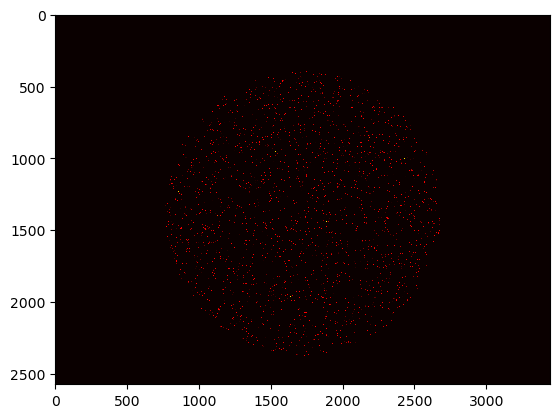

In [34]:
plt.imshow(pattern.H, cmap = 'hot', interpolation = 'nearest')